In [1]:
import numpy as np
from scipy import signal as sg
import matplotlib.pyplot as plt
from scipy import misc
from PIL import Image
import tensorflow as tf
%matplotlib inline

# Understanding Convolution

In [2]:
!wget --quiet https://ibm.box.com/shared/static/cn7yt7z10j8rx6um1v9seagpgmzzxnlz.jpg --output-document bird.jpg

In [3]:
im = Image.open('bird.jpg')

In [4]:
def map_edges(image, add_bias=True, plot_original=False, plot_map=True):
    
    image = image.convert('L')
    arr = np.asarray(image)
    
    if plot_original:
        plt.figure(figsize=(12, 8))
        plt.title("Grayscale Original Image")
        plt.imshow(arr, cmap='gray')
        plt.show()
    
    kernel = np.array([[ 0, 1, 0],
                   [ 1,-4, 1],
                   [ 0, 1, 0],]) 

    grad = sg.convolve2d(arr, kernel, mode='same', boundary='symm')
    
    if add_bias:
        grad = np.absolute(grad) + 100

        grad[grad > 255] = 255
        
    if plot_map:
        plt.figure(figsize=(12, 8))
        plt.title("Edge Detection Feature Map")
        plt.imshow(np.absolute(grad), cmap='gray')
        plt.show()
        
    return(grad)

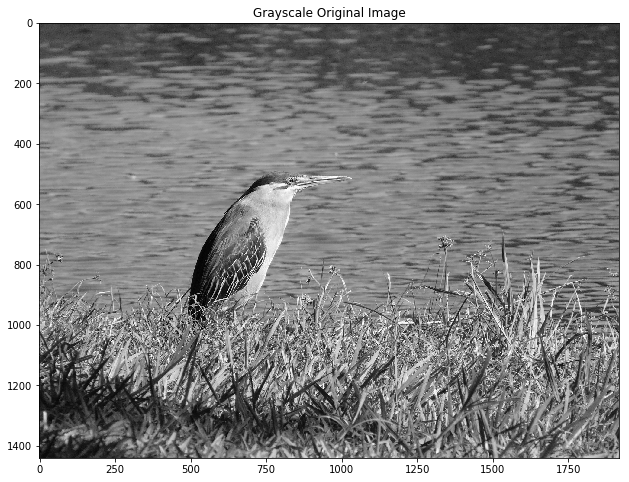

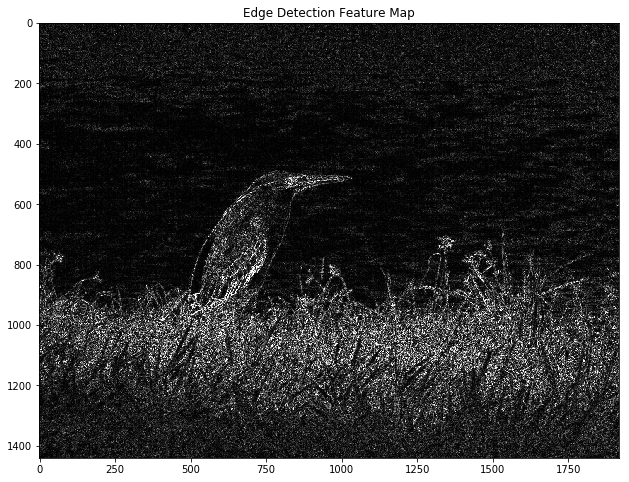

In [5]:
grad = map_edges(im, plot_original=True, plot_map=True)

In [6]:
!wget --quiet https://ibm.box.com/shared/static/vvm1b63uvuxq88vbw9znpwu5ol380mco.jpg --output-document num3.jpg    

In [7]:
im = Image.open('num3.jpg')

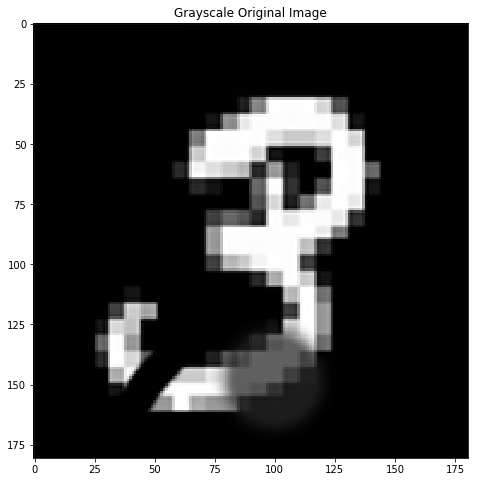

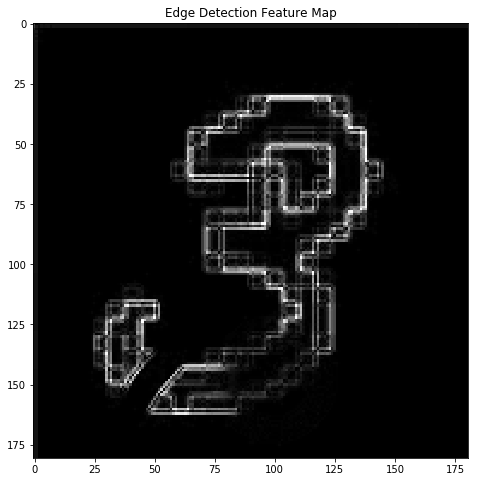

In [8]:
grad = map_edges(im, plot_original=True, plot_map=True)

In [9]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## Simple Regression

In [10]:
sess = tf.InteractiveSession()

In [11]:
X_place = tf.placeholder(tf.float32, shape=[None, 784])
y_place = tf.placeholder(tf.float32, shape=[None, 10])

In [12]:
W = tf.Variable(tf.zeros([784, 10],tf.float32))
b = tf.Variable(tf.zeros([10],tf.float32))

In [13]:
sess.run(tf.global_variables_initializer())

In [14]:
y = tf.nn.softmax(tf.add(tf.matmul(X_place, W) , b))

In [15]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_place * tf.log(y), reduction_indices=[1]))

In [16]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [17]:
for i in range(1000):
    batch = mnist.train.next_batch(50)
    train_step.run(feed_dict={X_place: batch[0], y_place: batch[1]})

In [18]:
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_place, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
acc = accuracy.eval(feed_dict={X_place: mnist.test.images, y_place: mnist.test.labels}) * 100
print("The final accuracy for the simple ANN model is: {} % ".format(acc) )

The final accuracy for the simple ANN model is: 90.9600019454956 % 


In [19]:
sess.close()

# CNN

In [20]:
sess = tf.InteractiveSession()

In [21]:
width = 28 # width of the image in pixels 
height = 28 # height of the image in pixels
flat = width * height # number of pixels in one image 
class_output = 10 # number of possible classifications for the problem

## Constructing the Network

Define the placeholders for X-data and y-data.

In [22]:
X_place  = tf.placeholder(tf.float32, shape=[None, flat])
y_place = tf.placeholder(tf.float32, shape=[None, class_output])

Reshape the image to a tensor of dimensions: [batch size, height, width, channels].

In [23]:
x_image = tf.reshape(X_place, [-1,28,28,1])  
x_image

<tf.Tensor 'Reshape:0' shape=(?, 28, 28, 1) dtype=float32>

__Convolution Layer 1__

We define our kernel here. Each filter/kernel window is of size 5x5 with 1 channel, and we want to apply 32 different filters on each image. Therefore the output of this laer would be 28x28x32.

In [24]:
W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, 32], stddev=0.1))
b_conv1 = tf.Variable(tf.constant(0.1, shape=[32]))

In [25]:
convolve1 = tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1

In [26]:
h_conv1 = tf.nn.relu(convolve1)

Here we have down-sampled using a 2x2 max-pool window. Therefore the dimensions will change from 28x28x32 to 14x14x32.

In [27]:
conv1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') #max_pool_2x2
conv1

<tf.Tensor 'MaxPool:0' shape=(?, 14, 14, 32) dtype=float32>

__Convolution Layer 2__

In this step, we create a filter / kernel tensor of shape [filter_height, filter_width, in_channels, out_channels]. Since now we have 32 channels, we write 32 instad of 1 and we want to apply 64 different kernels on it.

In [28]:
W_conv2 = tf.Variable(tf.truncated_normal([5, 5, 32, 64], stddev=0.1))
b_conv2 = tf.Variable(tf.constant(0.1, shape=[64]))

In [29]:
convolve2= tf.nn.conv2d(conv1, W_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2

In [30]:
h_conv2 = tf.nn.relu(convolve2)

In [31]:
conv2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') #max_pool_2x2
conv2

<tf.Tensor 'MaxPool_1:0' shape=(?, 7, 7, 64) dtype=float32>

The above resulting tensor is now of shape 7x7x64.

In [32]:
layer2_matrix = tf.reshape(conv2, [-1, 7 * 7 * 64]) #Flattening the tensor

__Fully Connected Layer 1__

Here, we have defined a fully connected layer of 1024 nodes.

In [33]:
W_fc1 = tf.Variable(tf.truncated_normal([7 * 7 * 64, 1024], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))

In [34]:
fcl = tf.matmul(layer2_matrix, W_fc1) + b_fc1

In [35]:
h_fc1 = tf.nn.relu(fcl)
h_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 1024) dtype=float32>

__Dropout Layer__

To prevent overfitting, we programme the network to "forget" some things. The drop layer switches off random units, so the associated weights are not updated.

In [36]:
keep_prob = tf.placeholder(tf.float32)
layer_drop = tf.nn.dropout(h_fc1, keep_prob)
layer_drop

<tf.Tensor 'dropout/mul:0' shape=(?, 1024) dtype=float32>

__Red-out Layer__

In [37]:
W_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))

In [38]:
fc = tf.matmul(layer_drop, W_fc2) + b_fc2

In [39]:
y_CNN = tf.nn.softmax(fc)
y_CNN

<tf.Tensor 'Softmax_1:0' shape=(?, 10) dtype=float32>

__Summary of the model__

- Input: 28x28x1 dimensions
- Convolutional Layer 1: 32 Kernels, ReLU and 2x2 Max-Pooling
- Convolutional Layer 1: 64 Kernels, ReLU and 2x2 Max-Pooling
- Flattening Layer
- Fully Connected Layer: 1024 nodes
- Dropout Layer
- Softmax Read-out layer
- 10 Outputs

## Training the Network

__Loss Function__

Cross-entropy loss, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. So predicting a probability of .012 when the actual observation label is 1 would be bad and result in a high loss value. 

In [40]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_place * tf.log(y_CNN), reduction_indices=[1]))

__Optimizer__

Adam optimizer, in most cases, is faster and more efficient than stochastic gradient descent.

In [41]:
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

__Accuracy__

Define correct predictions and accuracy.

In [42]:
correct_prediction = tf.equal(tf.argmax(y_CNN, 1), tf.argmax(y_place, 1))

In [43]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

__Training__

In [44]:
sess.run(tf.global_variables_initializer())

In [45]:
epochs = 1000
accuracy_vals = []

print("Steps\t\t Training Accuracy")
print("-----------------------------------------")
for i in range(epochs+1):
    batch = mnist.train.next_batch(50)
    if i%10 == 0:
        train_accuracy = accuracy.eval(feed_dict={X_place:batch[0], y_place: batch[1], keep_prob: 1.0})
        accuracy_vals.append(train_accuracy)
    if i%100 == 0:
        print(i, "\t\t", "{0:.2f}".format(float(train_accuracy)))
    train_step.run(feed_dict={X_place: batch[0], y_place: batch[1], keep_prob: 0.5})
print("-----------------------------------------")

Steps		 Training Accuracy
-----------------------------------------
0 		 0.08
100 		 0.76
200 		 0.94
300 		 0.96
400 		 0.90
500 		 0.94
600 		 0.94
700 		 0.92
800 		 0.90
900 		 0.92
1000 		 0.92
-----------------------------------------


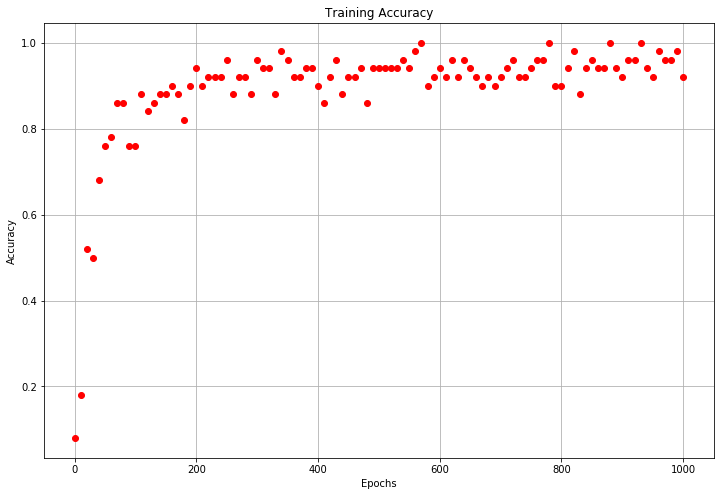

In [46]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(0, epochs+1, 10), accuracy_vals, 'ro')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.grid()
plt.show()

__Evaluation__

In [47]:
# evaluate in batches to avoid out-of-memory issues
n_batches = mnist.test.images.shape[0] // 50
cumulative_accuracy = 0.0
for index in range(n_batches):
    batch = mnist.test.next_batch(50)
    cumulative_accuracy += accuracy.eval(feed_dict={X_place: batch[0], y_place: batch[1], keep_prob: 1.0})
print("Test Accuracy = {0:.3f}".format(cumulative_accuracy / n_batches))

Test Accuracy = 0.963


In [48]:
sess.close()